# Dirichlet Process


## dataset

3가지 클러스터를 갖는 2차원 input데이터를 생성한다

In [1]:
import numpy as np
from sklearn import datasets
data_x, data_y = datasets.make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=0.5)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


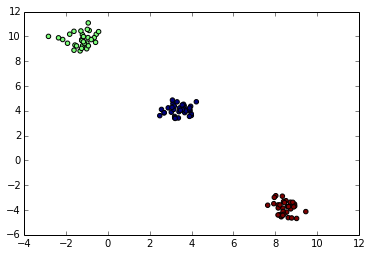

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(data_x[:,0], data_x[:,1], c=data_y)
plt.show()

## Cluster class

In [3]:
from numpy import random
class Cluster(object):
    def __init__(self, initial_datas=None, color=None):
        self.color = color if color else random.rand(3)
        self.assigned = initial_datas
        self.update()
        
    def __len__(self):
        return self._count
    
    def __str__(self):
        mu, cov = self.params()
        return 'mean:%s, cov:%s, members:%d, prob:%f'%(str(mu), str(cov.reshape((1,-1))), self.__len__(), self.probability(self.params()[0]))
        
    def params(self):
        return self._params
    
    def update(self):
        self._count = len(self.assigned)
        if self._count == 1:
            mu = np.array(self.assigned).mean(axis=0)
            cov = np.eye(mu.size)
        else:
            mu = np.array(self.assigned).mean(axis=0)
            cov = np.cov(self.assigned, rowvar=False)
        self._params = mu, cov

    def probability(self, point):
        mu, cov = self.params()
        from scipy.stats import multivariate_normal
        return min([1, multivariate_normal.pdf(point, mean=mu, cov=cov, allow_singular=True)])
    
    def plot(self, ax=None, **kwargs):
        if self.__len__() < 1:
            return
        from matplotlib.patches import Ellipse
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:,order]
        if ax is None:
            ax = plt.gca()
        mu, cov = self.params()
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        
        p = self.probability(mu)
        for nstd in range(1, 6):
            width, height = 2.0 * nstd * np.sqrt(vals)
            ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta, **kwargs)
            ax.add_artist( ellipse )
            ellipse.set_alpha( p * 0.1 )
            ellipse.set_facecolor(self.color)
        if self.assigned is not None:
            ax.scatter(np.array(self.assigned)[:,0], np.array(self.assigned)[:,1], c=self.color)


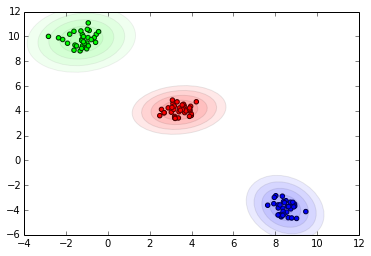

mean:[ 3.4014288   4.06758576], cov:[[ 0.20111212  0.02180392  0.02180392  0.15463833]], members:34, prob:0.909468
mean:[-1.27005255  9.75833182], cov:[[ 0.26831133  0.0322619   0.0322619   0.28107202]], members:33, prob:0.583592
mean:[ 8.46929018 -3.8230068 ], cov:[[ 0.13830824 -0.04185087 -0.04185087  0.27406191]], members:33, prob:0.837037


In [4]:
gt_clusters = [Cluster([data_x[i,:] for i, v in enumerate(data_y) if v==0], [1, 0, 0] ),
            Cluster(np.array([data_x[i,:] for i, v in enumerate(data_y) if v==1]), [0, 1, 0] ),
            Cluster(np.array([data_x[i,:] for i, v in enumerate(data_y) if v==2]), [0, 0, 1] ) ]

fig = plt.figure(0)
ax = fig.add_subplot(111)
[c.plot(ax) for c in gt_clusters]
plt.show()

for c in gt_clusters:
    print c

## Dirichlet Process (CRP)

In [5]:
def assigne(data, N, clusters, alpha=5.0):
    assigne_probability = [c.probability(data) * (len(c)) / ( N-1.0+alpha ) for c in clusters]
    assigne_probability += [max(assigne_probability) * alpha / ( N-1.0+alpha )] # create probability
    assigne_probability = [p/sum(assigne_probability) for p in assigne_probability]
    cummulative_probability = [0.0]
    for i, p in enumerate(assigne_probability):
        cummulative_probability.append( cummulative_probability[-1] + p )
    cummulative_probability[-1] += 1e-4
    
    sample_y = np.random.uniform()
    cluster_idx = [i for i, p in enumerate(cummulative_probability[:-1]) if p<=sample_y and sample_y<=cummulative_probability[i+1] ][0]
    return cluster_idx

In [6]:
class DirichletProcess(object):
    def __init__(self, datas):
        self.datas = datas
        self.idxs = [0 for i in datas]
        self.clusters = []
        
    def __str__(self, verbose=False):
        _ = 'alpha:%f #clusters: %d'%(alpha, len(self.clusters))
        if verbose:
            _ += '\n'
            for c in self.clusters:
                _ += '%s\n'%(str(c))
        return _
    
    def iter(self, alpha=1.0):
        for i, data in enumerate(self.datas):
            clusters = []
            for idx in range(max(self.idxs)+1):
                samples = [data_x[k,:] for k, v in enumerate(self.idxs) if v==idx and k!=i]
                if len(samples)>0:
                    clusters.append( Cluster(samples) )

            index = assigne(data, len(self.datas), clusters)
            self.idxs[i] = index
        self.clusters = clusters
    
    def plot(self, ax=None):
        
        if ax is None:
            fig = plt.figure(0)
            ax = fig.add_subplot(111)
        [c.plot(ax) for c in self.clusters]
        plt.show()

In [7]:
dp = DirichletProcess(data_x)

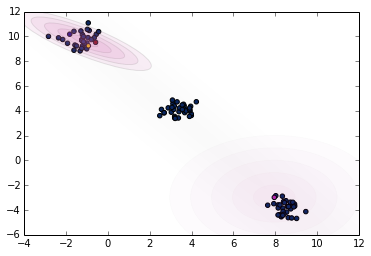

alpha:1.000000 #clusters: 3
alpha:1.000000 #clusters: 3


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in sqrt


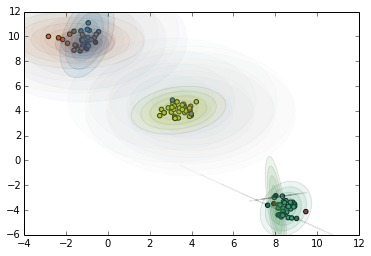

alpha:1.000000 #clusters: 15


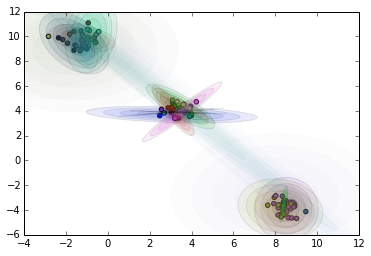

alpha:1.000000 #clusters: 22


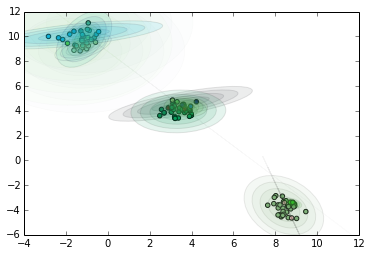

alpha:1.000000 #clusters: 14


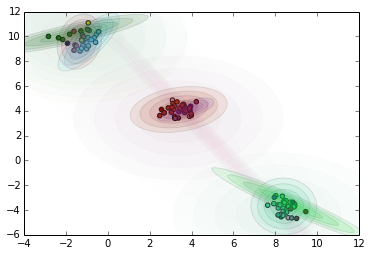

alpha:1.000000 #clusters: 15


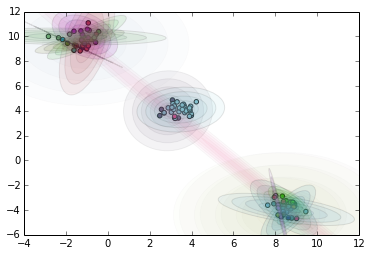

alpha:1.000000 #clusters: 18


In [8]:
alpha = 1.0

dp.iter(alpha)
dp.plot()
print dp

print dp
for k in range(5):
    for i in range(30):
        dp.iter(alpha)
    dp.plot()
    print dp

In [9]:
print dp.__str__(verbose=True)

alpha:1.000000 #clusters: 18
mean:[ 2.87249012  4.00112051], cov:[[ 0.18098346  0.00535598  0.00535598  0.41574403]], members:4, prob:0.580324
mean:[ 3.48232947  4.09655216], cov:[[ 0.17564282  0.01439078  0.01439078  0.13126593]], members:28, prob:1.000000
mean:[ 8.41119875 -3.81645519], cov:[[ 0.1028671  -0.10436444 -0.10436444  0.20264143]], members:6, prob:1.000000
mean:[ 8.69679651 -3.41354752], cov:[[ 0.04307529 -0.03910278 -0.03910278  0.06992556]], members:8, prob:1.000000
mean:[ 8.61813892 -4.2664578 ], cov:[[ 0.06863999  0.08991655  0.08991655  0.20942081]], members:3, prob:1.000000
mean:[ 8.17525789 -3.94447977], cov:[[ 0.00939296 -0.06224132 -0.06224132  0.43421007]], members:6, prob:1.000000
mean:[-1.31332705  9.17563123], cov:[[ 0.18879882  0.17829988  0.17829988  0.16838478]], members:2, prob:0.667520
mean:[-1.0077116   9.91820127], cov:[[ 0.14237142  0.11747922  0.11747922  0.12572398]], members:4, prob:1.000000
mean:[-1.34941502  9.57052285], cov:[[ 0.18176668  0.06401